In [1]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from loaders.Loaders import CSVLoader
from splitters.splitters import SingletaskStratifiedSplitter
from metrics.Metrics import Metric
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, matthews_corrcoef, precision_score)
from tensorflow.keras.layers import Dense, Dropout, GaussianNoise, Conv1D, Flatten, Reshape, LSTM, Bidirectional
from models.kerasModels import KerasModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop

import tensorflow as tf
print(tf.version.VERSION)

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings('ignore')

2.7.0


# CHECK GPU

In [2]:
tf.config.experimental.list_physical_devices('GPU')

2022-01-20 23:37:41.652275: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:41.659391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:41.659855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Using GPU: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Num GPUs Available:  1


2022-01-20 23:37:41.676948: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using GPU: /device:GPU:0


2022-01-20 23:37:41.677639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:41.678127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:41.678470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:42.301926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:42.302270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

# Load

In [4]:
rdk_path = '/home/laptop16/Desktop/Mestrado/2_ano/SIB/Grupo/CODE_SIB/src/smiles/dataset/binary_class/rdk_fs_all.csv'

bits = [0,5,25,34,36,55,77,78,101,103,105,106,113,117,128,129,142,175,188,194,195,196,197,200,203,211,231,270,274,278,281,291,309,335,365,382,386,388,400,406,411,419,427,438,443,461,471,492,498,515,516,522,532,549,563,586,589,594,608,620,632,636,640,668,671,674,676,684,697,701,704,707,719,728,734,738,742,759,779,791,798,799,838,841,847,853,857,865,870,876,883,887,927,935,940,955,962,972,985,992,1016,1024,1037,1043,1045,1051,1072,1097,1104,1113,1123,1130,1133,1134,1145,1155,1180,1184,1222,1238,1255,1265,1287,1288,1295,1302,1305,1338,1341,1342,1346,1347,1369,1374,1375,1377,1389,1400,1403,1420,1421,1451,1456,1472,1479,1483,1492,1494,1500,1501,1520,1522,1528,1533,1536,1542,1545,1548,1556,1579,1599,1605,1612,1652,1656,1667,1670,1672,1676,1681,1682,1685,1686,1699,1705,1707,1727,1732,1734,1771,1778,1792,1818,1820,1823,1832,1846,1849,1861,1867,1872,1876,1885,1889,1892,1915,1921,1931,1942,1971,1973,1992,1995,2003,2041]

str_bits = list(str(x) for x in bits)

In [5]:
loader = CSVLoader(rdk_path, mols_field='smiles', labels_fields='activity', features_fields=str_bits)

In [6]:
dataset = loader.create_dataset()
dataset.get_shape()

Mols_shape:  39990
Features_shape:  (39990, 205)
Labels_shape:  (39990,)


# Data Split

In [7]:
splitter = SingletaskStratifiedSplitter()
# train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset, frac_train=0.8)

input_dim = train_dataset.X.shape[1]

(31992, 205)
X not defined!
Defined features extracted!
(7998, 205)


# Model

In [8]:
def metrics(label_test, predict):
    print('METRICS:')
    print(f"Accuracy score:\n{accuracy_score(label_test, predict)}\n")
    print(f"Recall score:\n{recall_score(label_test, predict, average='macro')}\n")
    print(f"Precison score:\n{precision_score(label_test, predict, average='macro', zero_division=0)}\n")
    print(f"F1-score:\n{f1_score(label_test, predict, average='macro')}\n")
    print(f"MCC score:\n{matthews_corrcoef(label_test, predict)}\n")
    print(f"Confusion matrix:\n{confusion_matrix(label_test, predict)}\n")
    print(f"Classification report:\n{classification_report(label_test, predict, zero_division=0, digits=3)}\n")

## DNN

In [9]:
dnn = Sequential()
dnn.add(Dense(1024, input_dim=input_dim, activation='relu'))
dnn.add(Dropout(0.2))
dnn.add(Dense(256, activation='relu'))
dnn.add(Dense(64, activation='relu'))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1, activation='sigmoid'))
# Compile model
dnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

2022-01-20 23:37:43.836880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:43.837404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:43.837746: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:43.838124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 23:37:43.838576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [10]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              210944    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 490,321
Trainable params: 490,321
Non-trai

In [11]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_dnn = dnn.fit(train_dataset.X, train_dataset.y, validation_split=0.2, epochs=8, batch_size=150, verbose=1)

Train data size: (31992, 205)
Train labels size: (31992,)
Epoch 1/8
171/171 [==============================] - 2s 5ms/step - loss: 0.5627 - binary_accuracy: 0.7081 - val_loss: 0.8214 - val_binary_accuracy: 0.5596
Epoch 2/8
171/171 [==============================] - 1s 4ms/step - loss: 0.4955 - binary_accuracy: 0.7576 - val_loss: 0.6620 - val_binary_accuracy: 0.6696
Epoch 3/8
171/171 [==============================] - 1s 4ms/step - loss: 0.4503 - binary_accuracy: 0.7827 - val_loss: 0.8911 - val_binary_accuracy: 0.5506
Epoch 4/8
171/171 [==============================] - 1s 4ms/step - loss: 0.4111 - binary_accuracy: 0.8095 - val_loss: 0.9556 - val_binary_accuracy: 0.4971
Epoch 5/8
171/171 [==============================] - 1s 4ms/step - loss: 0.3768 - binary_accuracy: 0.8293 - val_loss: 0.8114 - val_binary_accuracy: 0.6545
Epoch 6/8
171/171 [==============================] - 1s 4ms/step - loss: 0.3503 - binary_accuracy: 0.8436 - val_loss: 1.1339 - val_binary_accuracy: 0.5216
Epoch 7/8
17

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


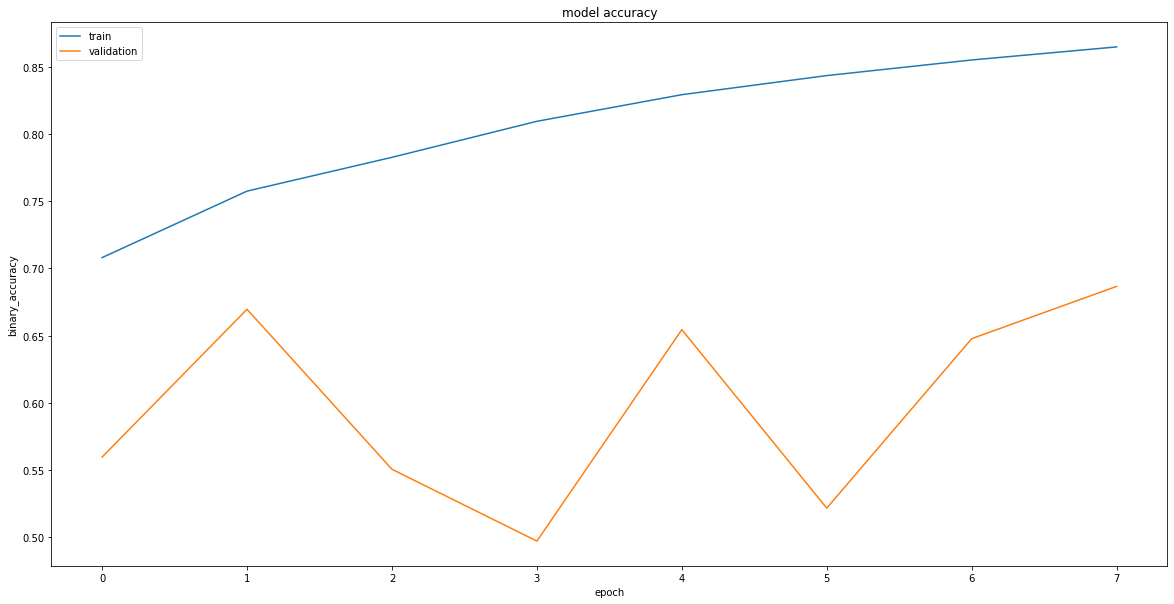

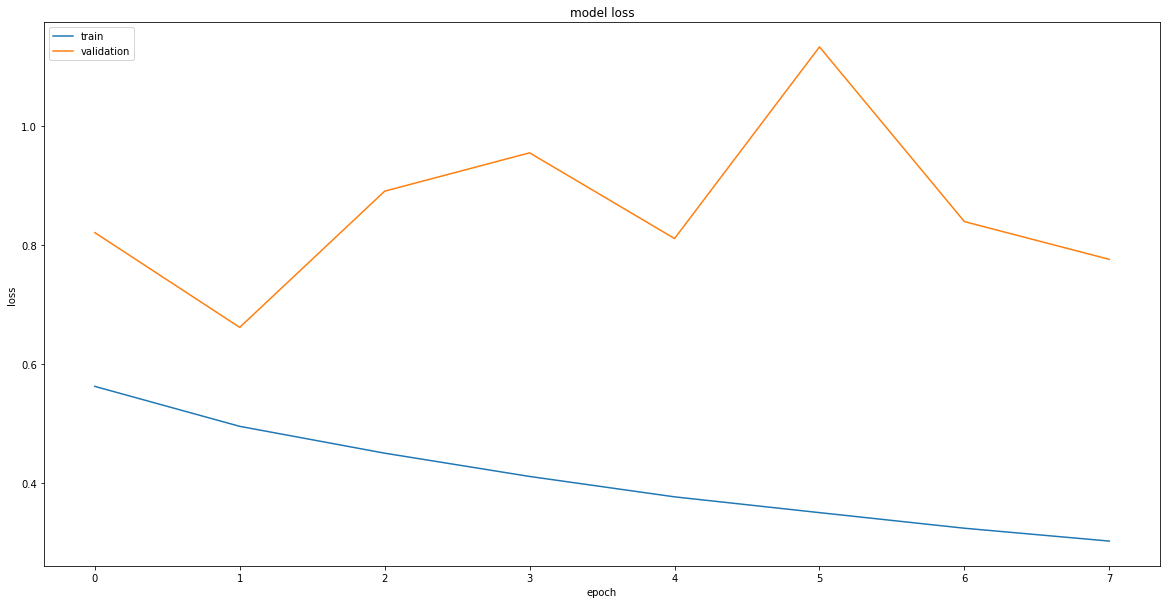

In [12]:
print(history_dnn.history.keys())
# summarize history for accuracy
plt.plot(history_dnn.history['binary_accuracy'])
plt.plot(history_dnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_dnn.history['loss'])
plt.plot(history_dnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
pred_dnn = dnn.predict(test_dataset.X)

In [14]:
pred_dnn_bin= np.where(pred_dnn >= 0.50, 1,0)

In [15]:
metrics(test_dataset.y, pred_dnn_bin)

METRICS:
Accuracy score:
0.769817454363591

Recall score:
0.769817454363591

Precison score:
0.7707846560501239

F1-score:
0.7696117263784323

MCC score:
0.5406012451934049

Confusion matrix:
[[3198  801]
 [1040 2959]]

Classification report:
              precision    recall  f1-score   support

           0      0.755     0.800     0.776      3999
           1      0.787     0.740     0.763      3999

    accuracy                          0.770      7998
   macro avg      0.771     0.770     0.770      7998
weighted avg      0.771     0.770     0.770      7998




## CNN

In [16]:
g_noise = 0.05
C1_K=8
C1_S=32
C2_K=16
C2_S=32
learning_rate=0.01

In [17]:
cnn = Sequential()
#Adding a bit of GaussianNoise also works as regularization
cnn.add(GaussianNoise(g_noise, input_shape=(input_dim,)))
#First two is number of filter + kernel size
cnn.add(Reshape((input_dim, 1)))
cnn.add(Conv1D(C1_K, (C1_S), activation='relu', padding="same"))
cnn.add(Conv1D(C2_K, (C2_S), padding="same", activation='relu'))
cnn.add(Flatten())
cnn.add(Dropout(0.2))
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [18]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 205)              0         
 se)                                                             
                                                                 
 reshape (Reshape)           (None, 205, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 205, 8)            264       
                                                                 
 conv1d_1 (Conv1D)           (None, 205, 16)           4112      
                                                                 
 flatten (Flatten)           (None, 3280)              0         
                                                                 
 dropout_1 (Dropout)         (None, 3280)              0         
                                                      

In [19]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_cnn = cnn.fit(train_dataset.X, train_dataset.y, validation_split=0.2, epochs=8, batch_size=150, verbose=1)

Train data size: (31992, 205)
Train labels size: (31992,)
Epoch 1/8


2022-01-20 23:37:53.021894: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


171/171 [==============================] - 4s 11ms/step - loss: 0.5666 - binary_accuracy: 0.7049 - val_loss: 0.6828 - val_binary_accuracy: 0.6174
Epoch 2/8
171/171 [==============================] - 1s 8ms/step - loss: 0.5121 - binary_accuracy: 0.7479 - val_loss: 0.7998 - val_binary_accuracy: 0.5435
Epoch 3/8
171/171 [==============================] - 1s 8ms/step - loss: 0.4799 - binary_accuracy: 0.7763 - val_loss: 0.8197 - val_binary_accuracy: 0.5152
Epoch 4/8
171/171 [==============================] - 1s 8ms/step - loss: 0.4529 - binary_accuracy: 0.7891 - val_loss: 0.6850 - val_binary_accuracy: 0.6235
Epoch 5/8
171/171 [==============================] - 1s 8ms/step - loss: 0.4247 - binary_accuracy: 0.8064 - val_loss: 0.8234 - val_binary_accuracy: 0.5637
Epoch 6/8
171/171 [==============================] - 1s 8ms/step - loss: 0.3949 - binary_accuracy: 0.8238 - val_loss: 0.7714 - val_binary_accuracy: 0.5985
Epoch 7/8
171/171 [==============================] - 1s 8ms/step - loss: 0.3701

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


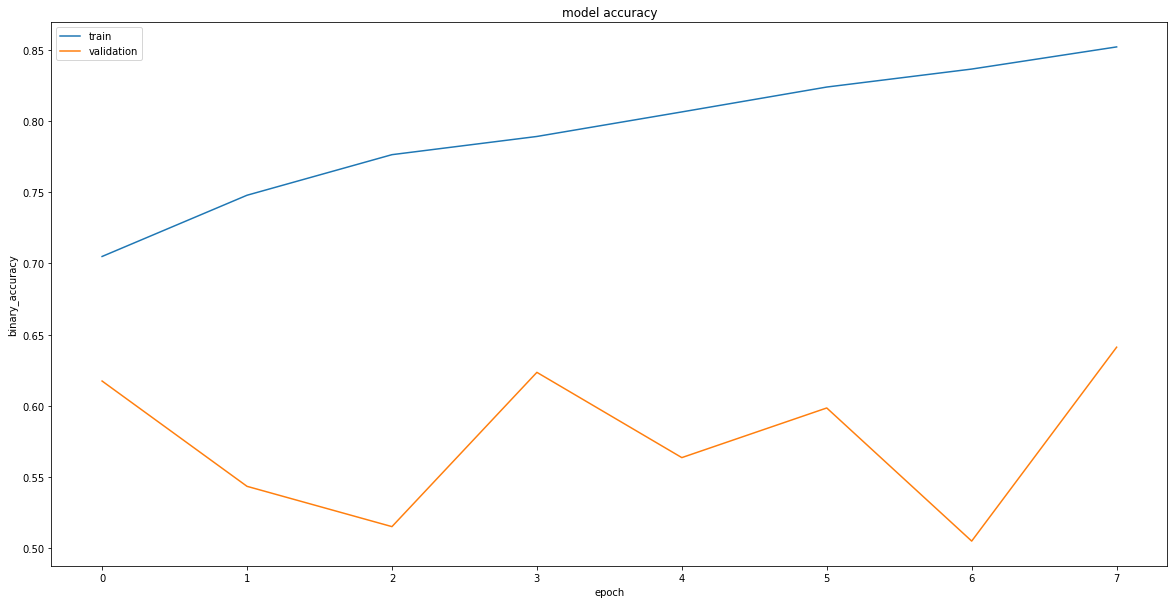

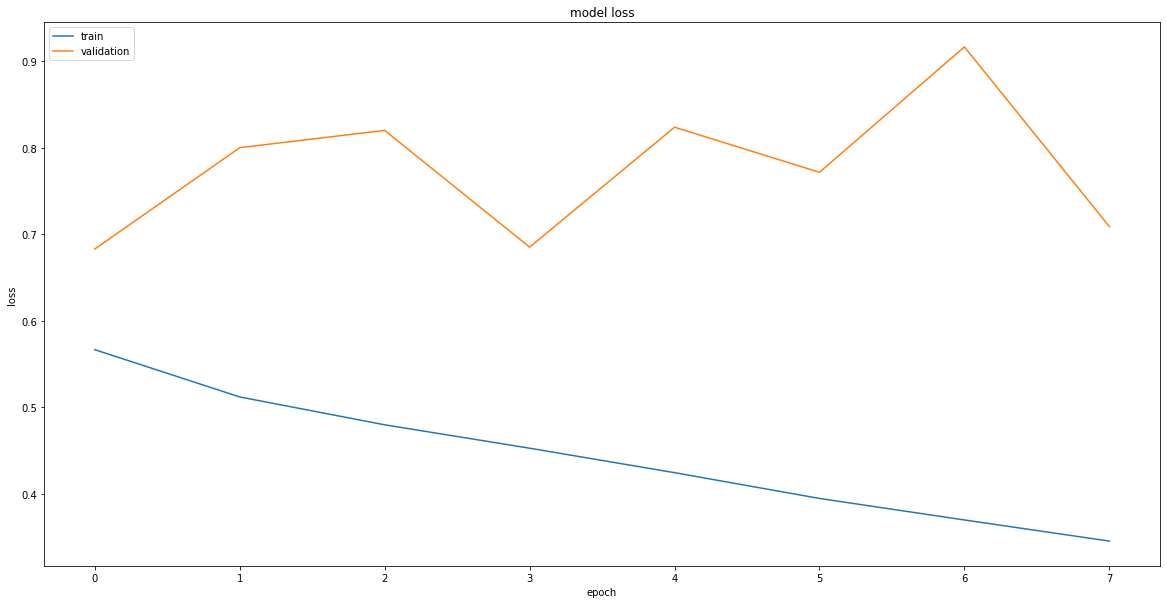

In [20]:
print(history_cnn.history.keys())
# summarize history for accuracy
plt.plot(history_cnn.history['binary_accuracy'])
plt.plot(history_cnn.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
pred_cnn = cnn.predict(test_dataset.X)

In [22]:
pred_cnn_bin = np.where(pred_cnn >= 0.50, 1, 0)

In [23]:
metrics(test_dataset.y, pred_cnn_bin)

METRICS:
Accuracy score:
0.7625656414103525

Recall score:
0.7625656414103525

Precison score:
0.7664200184764071

F1-score:
0.7617037659168839

MCC score:
0.5289716175214538

Confusion matrix:
[[3290  709]
 [1190 2809]]

Classification report:
              precision    recall  f1-score   support

           0      0.734     0.823     0.776      3999
           1      0.798     0.702     0.747      3999

    accuracy                          0.763      7998
   macro avg      0.766     0.763     0.762      7998
weighted avg      0.766     0.763     0.762      7998




## LSTM

In [24]:
x = np.reshape(train_dataset.X, (-1, 1, train_dataset.X.shape[1]))
y = np.reshape(train_dataset.y, (-1, 1, ))

In [25]:
xt = np.reshape(test_dataset.X, (-1, 1, test_dataset.X.shape[1]))
yt = np.reshape(test_dataset.y, (-1, 1, ))

In [26]:
x.shape

(31992, 1, 205)

In [27]:
y.shape

(31992, 1)

In [28]:
lstm = Sequential()
lstm.add(LSTM(128, input_shape=(x.shape[1], x.shape[2]), activation='relu', return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(64, return_sequences = True))
lstm.add(Dropout(0.2))
lstm.add(Dense(1, activation='sigmoid'))
# Compile model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [29]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            171008    
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 64)             49408     
                                                                 
 dropout_3 (Dropout)         (None, 1, 64)             0         
                                                                 
 dense_7 (Dense)             (None, 1, 1)              65        
                                                                 
Total params: 220,481
Trainable params: 220,481
Non-trainable params: 0
_________________________________________________________________


In [30]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_lstm = lstm.fit(x, y, validation_split=0.2, epochs=8, batch_size=150, verbose=1)

Train data size: (31992, 205)
Train labels size: (31992,)
Epoch 1/8
171/171 [==============================] - 5s 11ms/step - loss: 0.5930 - binary_accuracy: 0.6880 - val_loss: 0.8954 - val_binary_accuracy: 0.4477
Epoch 2/8
171/171 [==============================] - 1s 8ms/step - loss: 0.5268 - binary_accuracy: 0.7338 - val_loss: 0.8225 - val_binary_accuracy: 0.5202
Epoch 3/8
171/171 [==============================] - 1s 7ms/step - loss: 0.4921 - binary_accuracy: 0.7622 - val_loss: 0.9364 - val_binary_accuracy: 0.4857
Epoch 4/8
171/171 [==============================] - 1s 7ms/step - loss: 0.4616 - binary_accuracy: 0.7792 - val_loss: 0.9700 - val_binary_accuracy: 0.4801
Epoch 5/8
171/171 [==============================] - 1s 7ms/step - loss: 0.4358 - binary_accuracy: 0.7964 - val_loss: 0.9881 - val_binary_accuracy: 0.4834
Epoch 6/8
171/171 [==============================] - 1s 7ms/step - loss: 0.4109 - binary_accuracy: 0.8109 - val_loss: 0.8074 - val_binary_accuracy: 0.6096
Epoch 7/8
1

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


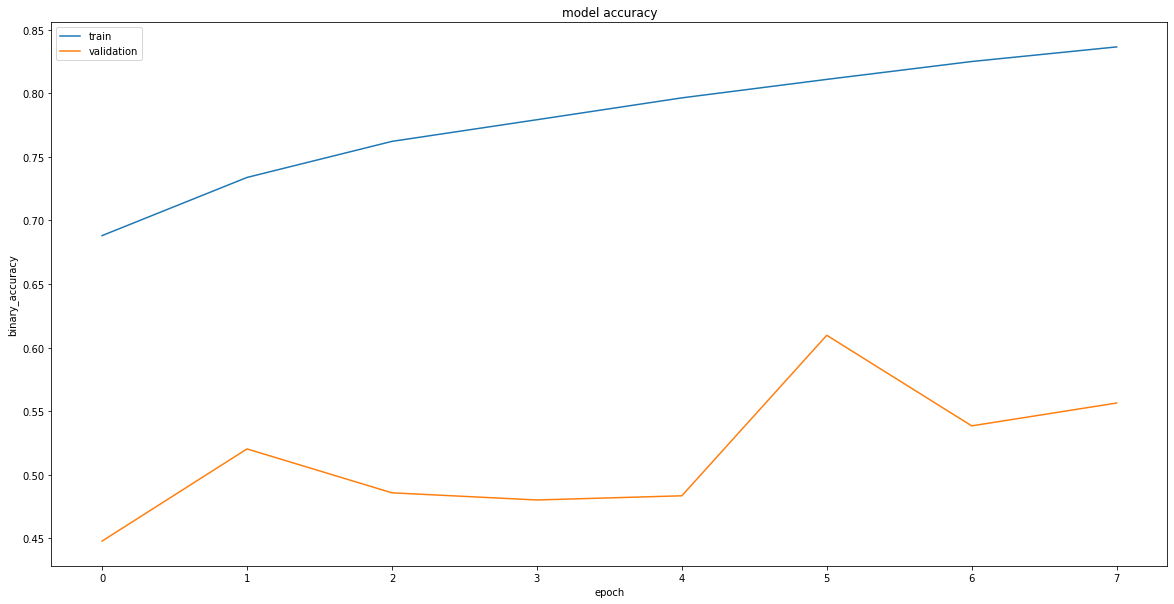

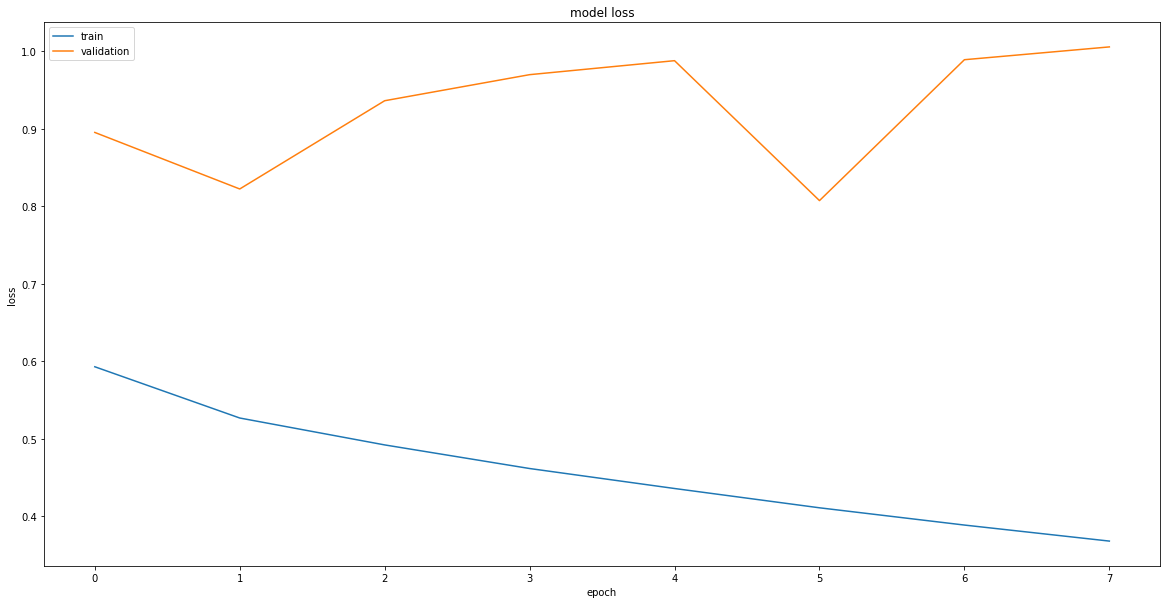

In [31]:
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['binary_accuracy'])
plt.plot(history_lstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
pred_lstm = lstm.predict(xt)

In [33]:
pred_lstm_bin = np.where(pred_lstm >= 0.50, 1, 0)

In [34]:
pred_lstm_bin.flatten()

array([0, 1, 0, ..., 0, 0, 0])

In [35]:
yt

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [36]:
metrics(yt, pred_lstm_bin.flatten())

METRICS:
Accuracy score:
0.7471867966991748

Recall score:
0.7471867966991748

Precison score:
0.7572252059666444

F1-score:
0.7446959379074584

MCC score:
0.504312104527267

Confusion matrix:
[[3383  616]
 [1406 2593]]

Classification report:
              precision    recall  f1-score   support

           0      0.706     0.846     0.770      3999
           1      0.808     0.648     0.719      3999

    accuracy                          0.747      7998
   macro avg      0.757     0.747     0.745      7998
weighted avg      0.757     0.747     0.745      7998




# Bi-LSTM

In [37]:
bilstm = Sequential()
bilstm.add(Bidirectional(LSTM(256, return_sequences = True), input_shape=(x.shape[1], x.shape[2])))
bilstm.add(Dropout(0.1))
bilstm.add(Bidirectional(LSTM(128, return_sequences = True)))
bilstm.add(Dropout(0.1))
bilstm.add(Bidirectional(LSTM(64, return_sequences = True)))
bilstm.add(Dropout(0.1))
bilstm.add(Dense(1, activation='sigmoid'))
# Compile model
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [38]:
bilstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 512)           946176    
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 1, 512)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1, 256)           656384    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 1, 256)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 128)           164352    
 nal)                                                            
                                                      

In [39]:
x.shape

(31992, 1, 205)

In [40]:
print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
history_bilstm = bilstm.fit(x, y, validation_split=0.2, epochs=8, batch_size=150, verbose=1)

Train data size: (31992, 205)
Train labels size: (31992,)
Epoch 1/8
171/171 [==============================] - 13s 27ms/step - loss: 0.5732 - binary_accuracy: 0.7022 - val_loss: 0.9458 - val_binary_accuracy: 0.4568
Epoch 2/8
171/171 [==============================] - 2s 12ms/step - loss: 0.5293 - binary_accuracy: 0.7346 - val_loss: 0.9054 - val_binary_accuracy: 0.4785
Epoch 3/8
171/171 [==============================] - 2s 12ms/step - loss: 0.4917 - binary_accuracy: 0.7622 - val_loss: 1.0511 - val_binary_accuracy: 0.4138
Epoch 4/8
171/171 [==============================] - 2s 12ms/step - loss: 0.4457 - binary_accuracy: 0.7920 - val_loss: 0.8395 - val_binary_accuracy: 0.5631
Epoch 5/8
171/171 [==============================] - 2s 12ms/step - loss: 0.4085 - binary_accuracy: 0.8142 - val_loss: 0.8988 - val_binary_accuracy: 0.5604
Epoch 6/8
171/171 [==============================] - 2s 12ms/step - loss: 0.3779 - binary_accuracy: 0.8296 - val_loss: 1.0367 - val_binary_accuracy: 0.5018
Epoch

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


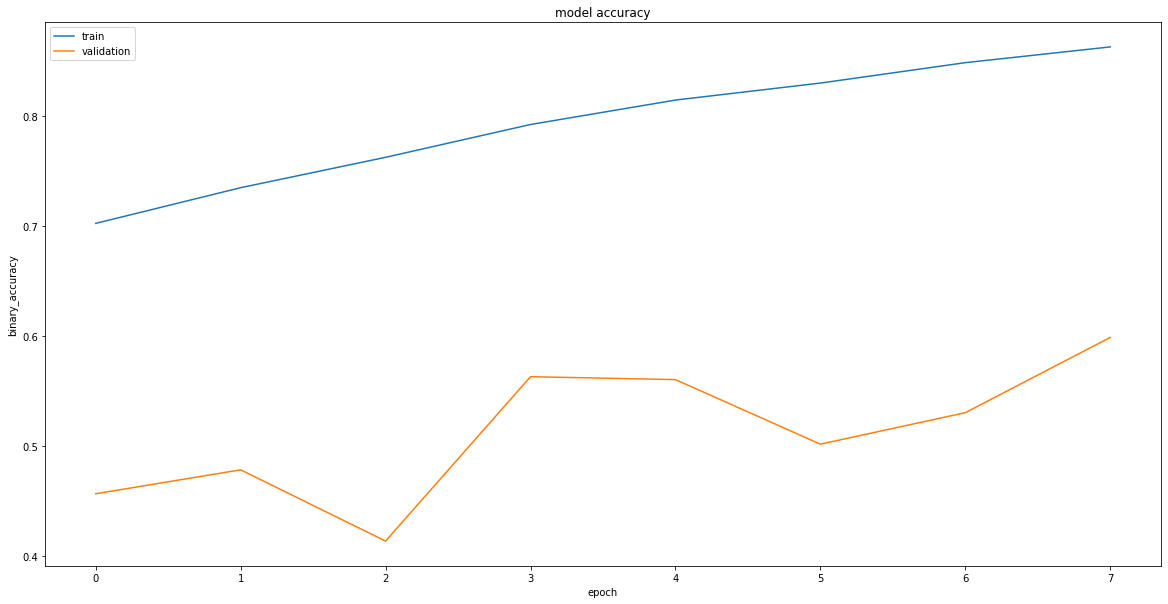

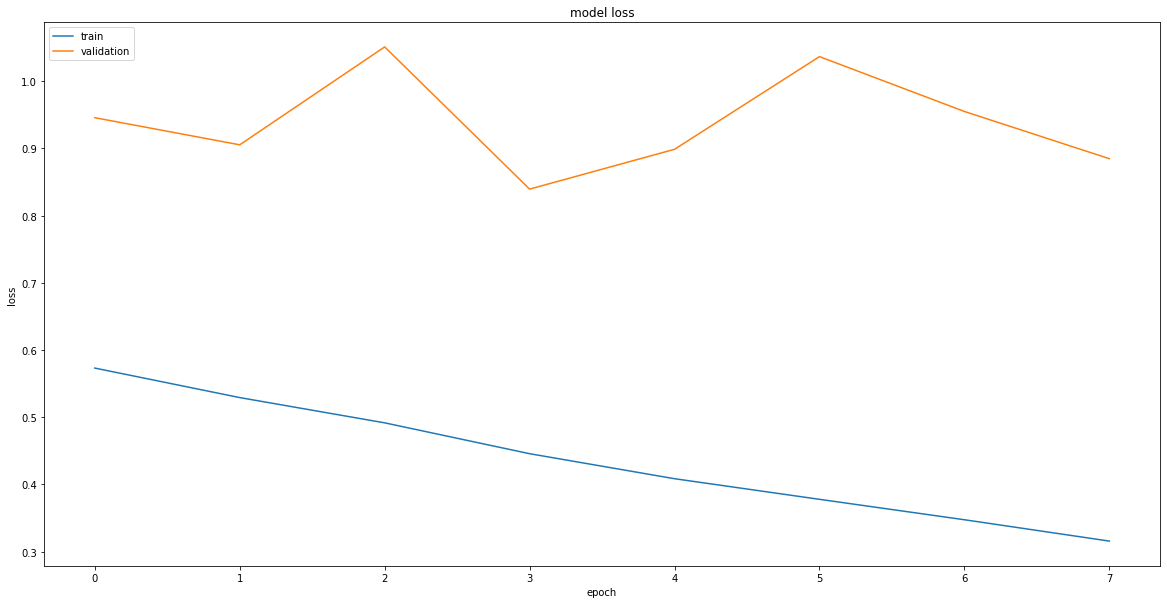

In [41]:
print(history_bilstm.history.keys())
# summarize history for accuracy
plt.plot(history_bilstm.history['binary_accuracy'])
plt.plot(history_bilstm.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_bilstm.history['loss'])
plt.plot(history_bilstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [42]:
pred_lstm = lstm.predict(xt)

In [43]:
pred_lstm_bin = np.where(pred_lstm >= 0.50, 1, 0)

In [44]:
metrics(yt, pred_lstm_bin.flatten())

METRICS:
Accuracy score:
0.7471867966991748

Recall score:
0.7471867966991748

Precison score:
0.7572252059666444

F1-score:
0.7446959379074584

MCC score:
0.504312104527267

Confusion matrix:
[[3383  616]
 [1406 2593]]

Classification report:
              precision    recall  f1-score   support

           0      0.706     0.846     0.770      3999
           1      0.808     0.648     0.719      3999

    accuracy                          0.747      7998
   macro avg      0.757     0.747     0.745      7998
weighted avg      0.757     0.747     0.745      7998




# OLD

In [45]:
# from metrics.metricsFunctions import roc_auc_score, precision_score, accuracy_score, confusion_matrix, classification_report
#
# def create_dnn_model(optimizer='adam', dropout=0.2, input_dim=input_dim):
#     # create model
#     model = Sequential()
#     model.add(Dense(1024, input_dim=input_dim, activation='relu'))
#     model.add(Dropout(dropout))
#     model.add(Dense(256, activation='relu'))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dense(8, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#     model.summary()
#     return model
#
# print(f'Input dim: {input_dim}')
# model = KerasModel(create_dnn_model, epochs=10, verbose=1, batch_size=150)
#
# print(f'Train data size: {train_dataset.X.shape}\nTrain labels size: {train_dataset.y.shape}')
# model.fit(train_dataset)
#
# metrics = [Metric(roc_auc_score),
#            Metric(precision_score),
#            Metric(accuracy_score),
#            Metric(confusion_matrix),
#            Metric(classification_report)]
#
# print('training set score:', model.evaluate(train_dataset, metrics))
# print('test set score:', model.evaluate(test_dataset, metrics))